In [1]:
# load dependencies
import csv
import geopandas as gpd
import pandas as pd
import shapely
import numpy as np
from scipy import ndimage

import matplotlib
from matplotlib.pyplot import figure
#import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from matplotlib.colors import ListedColormap
from matplotlib.ticker import MaxNLocator

In [2]:
save_plots = False

In [3]:
# Do housekeeping between runs
objects = ['neighborhoods',
           'census_income_data',
           'ids',
           'date',
           'ptype',
           'category',
           'location',
           'arrest',
           'community_area',
           'geometry',
           'crime_data',
           'crimes']

for thing in objects:
    try:
        del thing
    except NameError as e:
        print("Couldn't delete {0}".format(thing))
        print(e)
        continue


In [4]:
neighborhoods = gpd.read_file('community-areas.geojson')
census_income_data = gpd.read_file('census-tracts-2000.geojson')

In [5]:
ids = []
date = []
ptype = []
category = []
location = []
arrest = []
community_area = []
geometry = []

In [6]:
categories: dict = {"THEFT": "property",
                    "BURGLARY": "property",
                    "MOTOR VEHICLE THEFT": "property",
                    "ARSON": "property",
                    "CRIMINAL DAMAGE": "property",
                    "ROBBERY": "property",
                    "ASSAULT": "person",
                    "BATTERY": "person",
                    "CRIM SEXUAL ASSAULT": "person",
                    "HOMICIDE": "person",
                    "INTIMIDATION": "person",
                    "KIDNAPPING": "person",
                    "OFFENSE INVOLVING CHILDREN": "person",
                    "SEX OFFENSE": "person",
                    "STALKING": "person",
                    "GAMBLING": "vice",
                    "NARCOTICS": "vice",
                    "PROSTITUTION": "vice",
                    "LIQUOR LAW VIOLATION": "vice",
                    "OBSCENITY": "vice",
                    "OTHER NARCOTIC VIOLATION": "vice",
                    "PUBLIC INDECENCY": "vice",
                    "OTHER OFFENSE": "other",
                    "DECEPTIVE PRACTICE": "other",
                    "WEAPONS VIOLATION": "other",
                    "PUBLIC PEACE VIOLATION": "other",
                    "CRIMINAL TRESPASS": "other",
                    "INTERFERENCE WITH PUBLIC OFFICER": "other",
                    "NON-CRIMINAL": "other"
                   }

In [7]:
chunkfiles: list = ['crimes-2010-2011-0.csv', 'crimes-2010-2011-1.csv']

min_lat = 45.
max_lat = 41.
min_lon = -91.
max_lon = -91.

for chunk in chunkfiles:
    with open(chunk, "r") as crimes_fh:
        crimereader = csv.reader(crimes_fh)
        for row in crimereader:
            try:
                lat = float(row[19])
                if lat == 36.619446395:
                    continue
                lon = float(row[20])
                if lat < min_lat:
                    min_lat = lat
                    #print("Min lat found[{0}]: {1}x{2}".format(row[0], lat, lon))
                if lat > max_lat:
                    max_lat = lat
                    #print("Max lat found[{0}]: {1}x{2}".format(row[0], lat, lon))
                if lon < min_lon:
                    min_lon = lon
                    #print("Min lon found[{0}]: {1}x{2}".format(row[0], lat, lon))
                if lon > max_lon:
                    max_lon = lon
                    #print("Max lon found[{0}]: {1}x{2}".format(row[0], lat, lon))
            except Exception as e:
                continue
            ids.append(row[0])
            date.append(row[2].split(" ")[0])
            ptype.append(row[5])
            category.append(categories[row[5]])
            location.append(row[7])
            arrest.append(row[8])
            community_area.append(row[9])
            geometry.append(shapely.geometry.point.Point(lon, lat))

In [8]:
crime_data = {
        'date': pd.Series(date, index=ids),
        "primary type": pd.Series(ptype, index=ids, dtype="category"),
        "category": pd.Series(category, index=ids, dtype="category"),
        "location description": pd.Series(location, index=ids),
        "arrest": pd.Series(arrest, index=ids),
        "community area": pd.Series(community_area, index=ids),
        "geometry": pd.Series(geometry, index=ids)
        }

In [9]:
crimes = gpd.GeoDataFrame(crime_data, index=ids)

In [10]:
print(crimes.info())
print(crimes['primary type'].unique())
print(crimes['category'].unique())

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 721337 entries, 8265244 to 8198043
Data columns (total 7 columns):
date                    721337 non-null object
primary type            721337 non-null category
category                721337 non-null category
location description    721337 non-null object
arrest                  721337 non-null object
community area          721337 non-null object
geometry                721337 non-null object
dtypes: category(2), object(5)
memory usage: 34.4+ MB
None
[BURGLARY, DECEPTIVE PRACTICE, OFFENSE INVOLVING CHILDREN, OTHER OFFENSE, CRIM SEXUAL ASSAULT, ..., OBSCENITY, OTHER NARCOTIC VIOLATION, PUBLIC INDECENCY, HOMICIDE, NON-CRIMINAL]
Length: 29
Categories (29, object): [BURGLARY, DECEPTIVE PRACTICE, OFFENSE INVOLVING CHILDREN, OTHER OFFENSE, ..., OTHER NARCOTIC VIOLATION, PUBLIC INDECENCY, HOMICIDE, NON-CRIMINAL]
[property, other, person, vice]
Categories (4, object): [property, other, person, vice]


In [11]:
with open("sorted-census-tract-median-household-income.csv", "r") as tract_income:
    tract_income_list = list(csv.DictReader(tract_income))

In [12]:
tract_info_df = pd.DataFrame(tract_income_list)
with_incomes = pd.merge(census_income_data, tract_info_df, on="census_tra")

In [13]:
def heatmap(d, bins=(100,100), smoothing=1.3, cmap='jet'):
    def getx(pt):
        return pt.coords[0][0]

    def gety(pt):
        return pt.coords[0][1]

    x = list(d.geometry.apply(getx))
    y = list(d.geometry.apply(gety))
    heatmap, xedges, yedges = np.histogram2d(y, x, bins=bins)
    extent = [yedges[0], yedges[-1], xedges[-1], xedges[0]]

    logheatmap = np.log(heatmap)
    logheatmap[np.isneginf(logheatmap)] = 0
    logheatmap = ndimage.filters.gaussian_filter(logheatmap, smoothing, mode='nearest')
    return (logheatmap, extent)
    #plt.imshow(logheatmap, cmap=cmap, extent=extent)
    #plt.colorbar()
    #plt.gca().invert_yaxis()
    #plt.show()

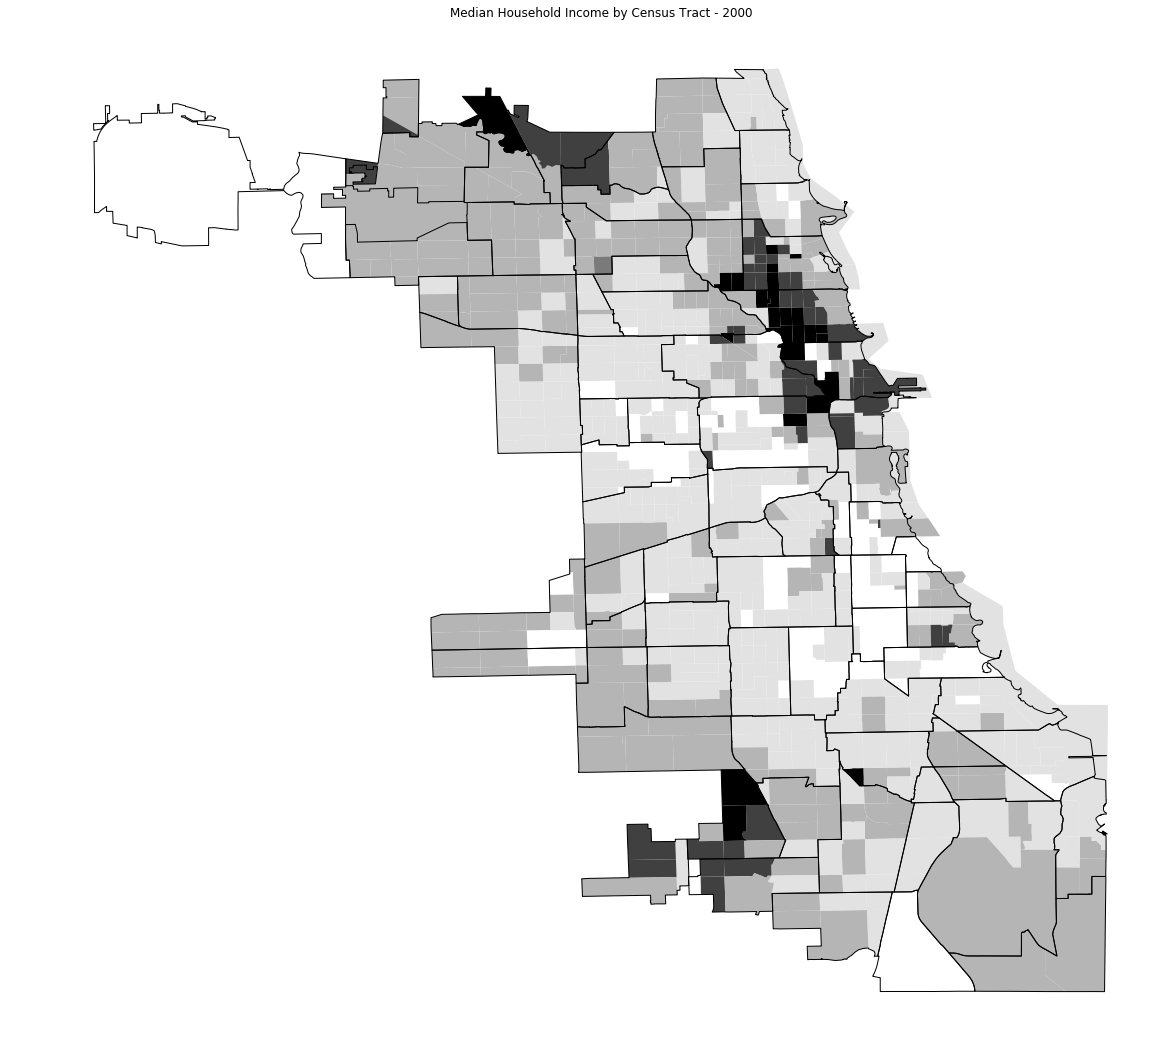

In [14]:
fig, ax = plt.subplots(figsize=(20, 20))

income_ranges = np.array(["",
                          "$0      - $20,000",
                          "$20,001 - $40,000",
                          "$40,001 - $60,000",
                          "$60,001 - $80,000",
                          "$80,001 +"
                         ])

ax.set_aspect('equal')
ax.axis('off')
    
#cMap = ListedColormap(["#333333", "#555555", "#999999", "#BBBBBB", "#EEEEEE"])
cMap = plt.get_cmap('Greys')
levels = np.linspace(0, 5, 6, dtype=int)
norm = matplotlib.colors.BoundaryNorm(levels, ncolors=cMap.N, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: income_ranges[::-1][norm(x)])
#wi_plot = with_incomes.plot(ax=ax, column="income_range",  cmap=cMap, legend=True)
#cb1 = matplotlib.colorbar.ColorbarBase(cmap="Greys",
#                                       norm=norm,
#                                       orientation='horizontal', ax=ax)

ax.set_title('Median Household Income by Census Tract - 2000')
with_incomes.plot(ax=ax, column="income_range",  cmap=cMap)
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

if save_plots:
    plt.savefig('census-mhi.png', bbox_inches='tight')
else:
    plt.show()

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


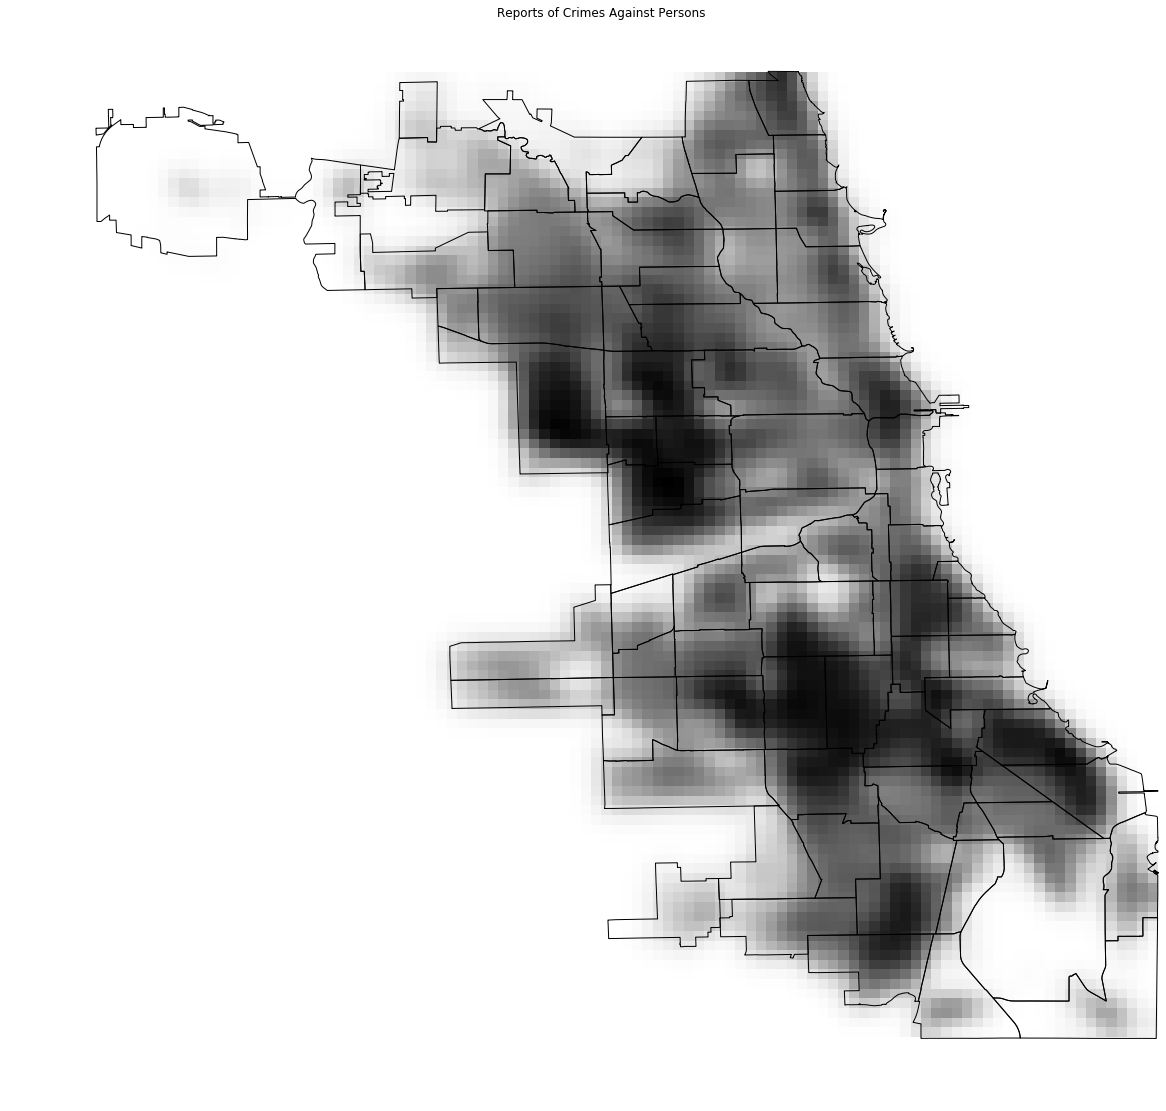

In [15]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Reports of Crimes Against Persons')
ax.set_aspect('equal')
ax.axis('off')
my_heatmap, extent = heatmap(crimes.loc[lambda crimes: crimes['category'] == 'person', :],
                             bins=(100, 100), smoothing=1.3, cmap=cMap)
plt.imshow(my_heatmap, extent=extent, cmap=cMap)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

if save_plots:
    plt.savefig('police-reports-person.png', bbox_inches='tight')
else:
    plt.show()

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


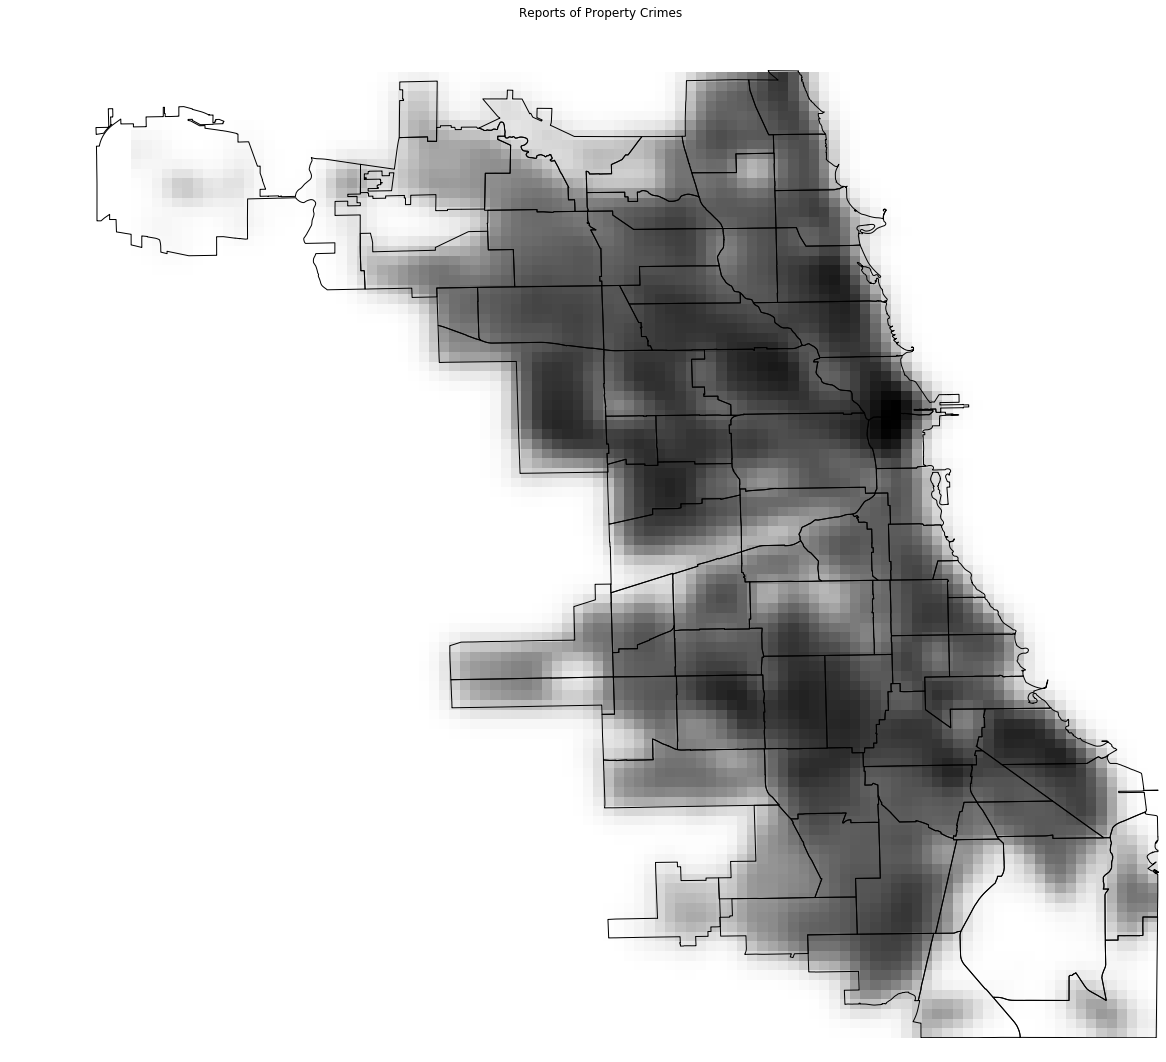

In [16]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Reports of Property Crimes')
ax.set_aspect('equal')
ax.axis('off')
my_heatmap, extent = heatmap(crimes.loc[lambda crimes: crimes['category'] == 'property', :],
                             bins=(100, 100), smoothing=1.3, cmap=cMap)
plt.imshow(my_heatmap, extent=extent, cmap=cMap)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

if save_plots:
    plt.savefig('police-reports-property.png', bbox_inches='tight')
else:
    plt.show()

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


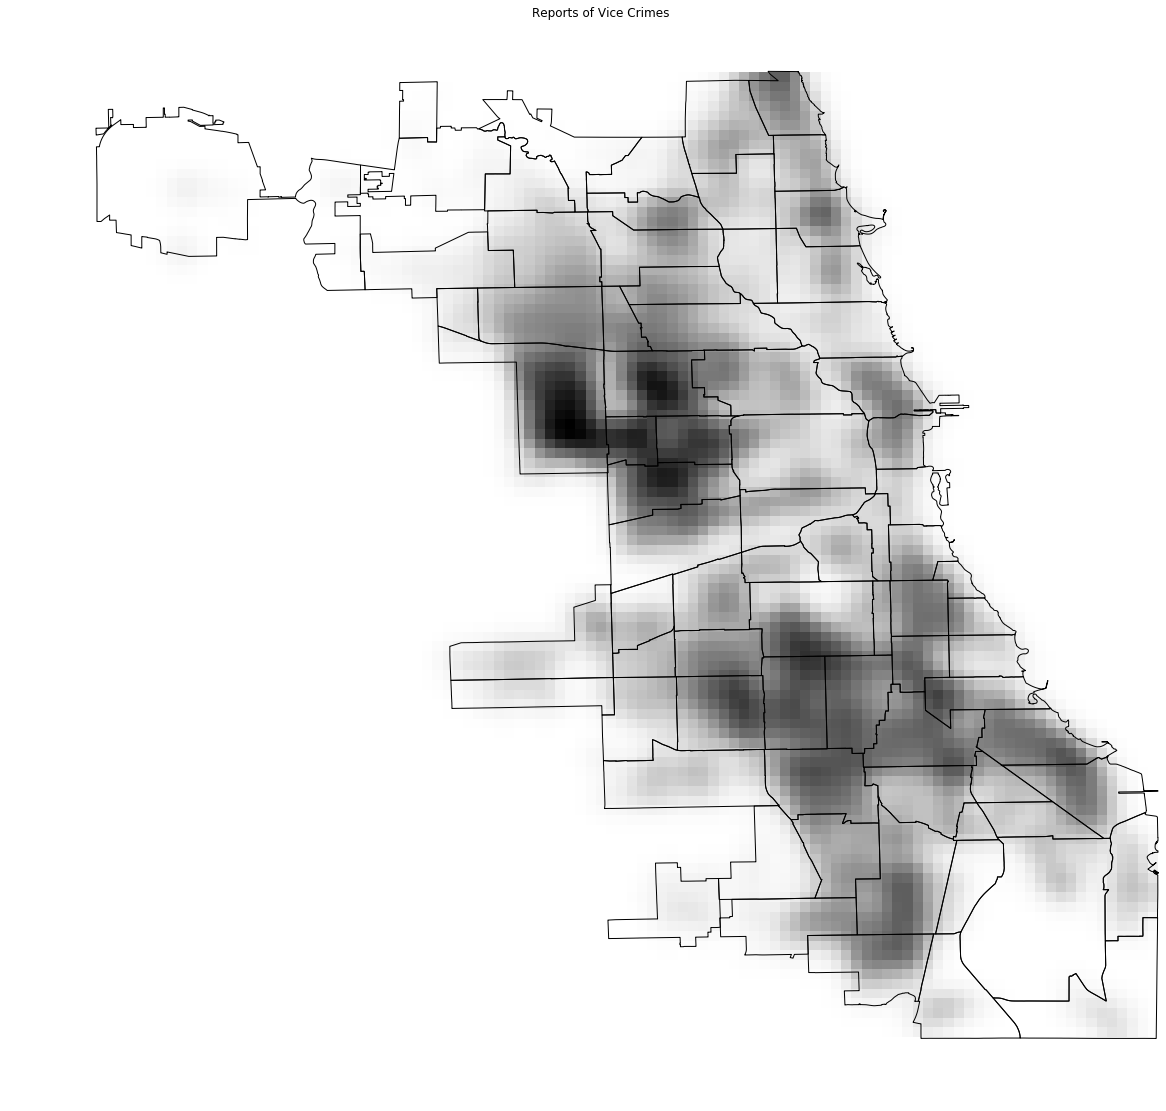

In [17]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Reports of Vice Crimes')
ax.set_aspect('equal')
ax.axis('off')
my_heatmap, extent = heatmap(crimes.loc[lambda crimes: crimes['category'] == 'vice', :],
                             bins=(100, 100), smoothing=1.3, cmap=cMap)
plt.imshow(my_heatmap, extent=extent, cmap=cMap)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

if save_plots:
    plt.savefig('police-reports-vice.png', bbox_inches='tight')
else:
    plt.show()

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


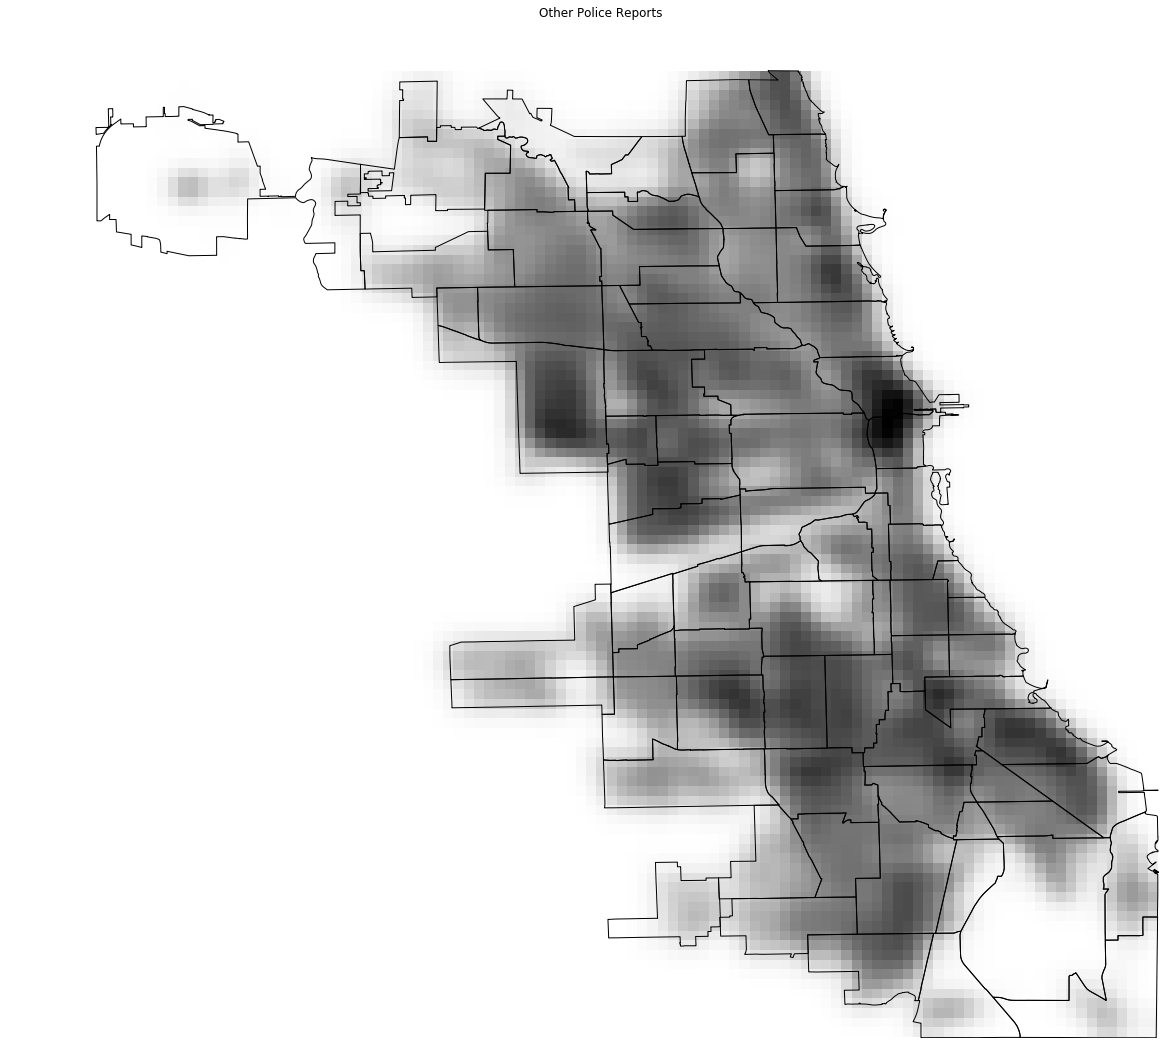

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))

ax.set_title('Other Police Reports')
ax.set_aspect('equal')
ax.axis('off')
my_heatmap, extent = heatmap(crimes.loc[lambda crimes: crimes['category'] == 'other', :],
                             bins=(100, 100), smoothing=1.3, cmap=cMap)
plt.imshow(my_heatmap, extent=extent, cmap=cMap)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

if save_plots:
    plt.savefig('police-reports-other.png', bbox_inches='tight')
else:
    plt.show()

/Users/jon/anaconda3/envs/geospatial/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


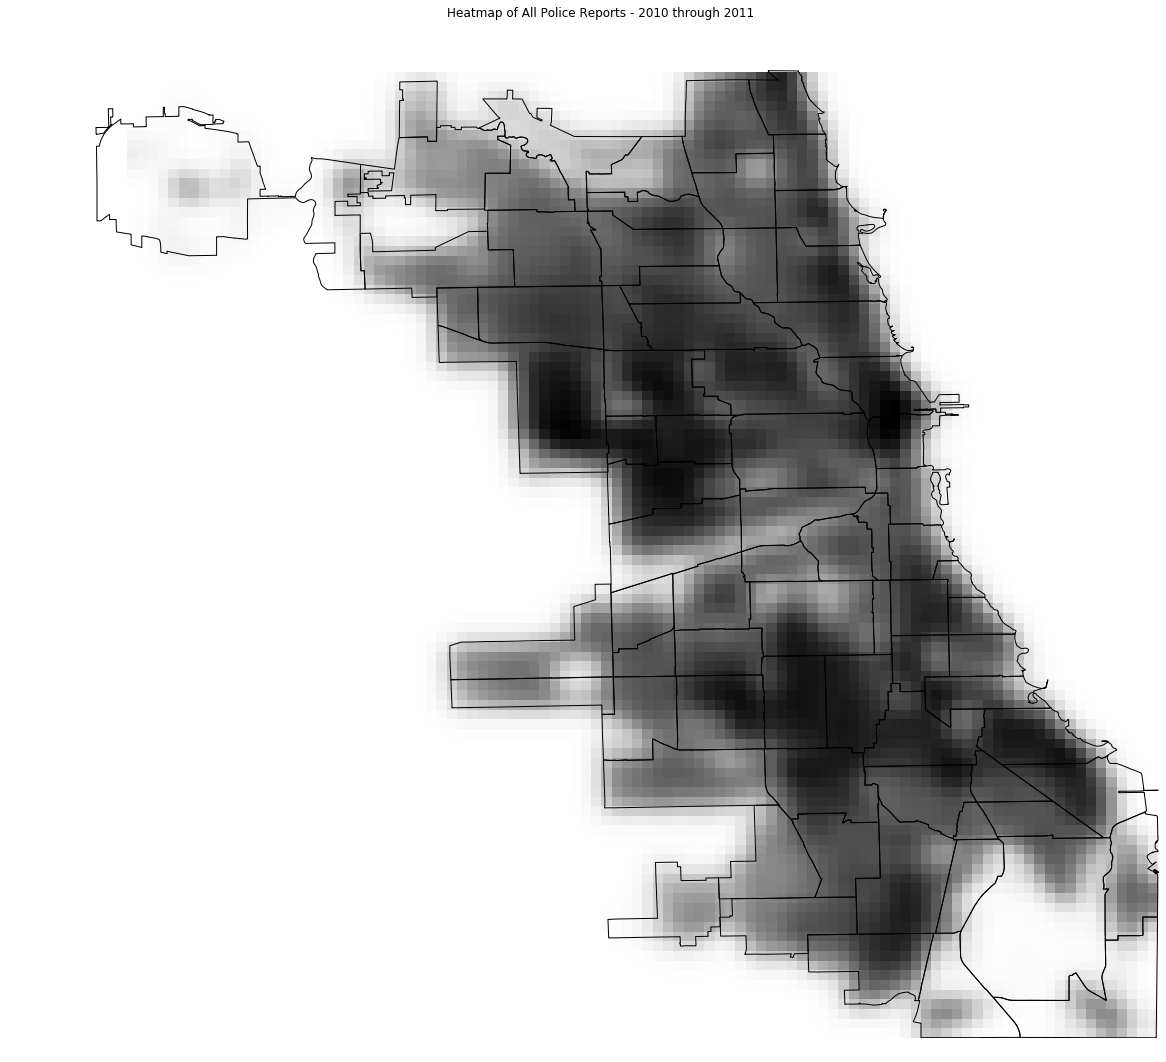

In [19]:
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_aspect('equal')
ax.set_title('Heatmap of All Police Reports - 2010 through 2011')
ax.axis("off")
#plt.imshow(logheatmap, cmap=cMap, extent=extent)
my_heatmap, extent = heatmap(crimes, bins=(100, 100), smoothing=1.3, cmap=cMap)
plt.imshow(my_heatmap, extent=extent, cmap=cMap)
plt.gca().invert_yaxis()
neighborhoods.plot(ax=ax, edgecolor='black', color='none')

if save_plots:
    plt.savefig('police-reports-all.png', bbox_inches='tight')
else:
    plt.show()